## Линейная регрессия: переобучение и регуляризация

как переобучаются линейные модели, почему, как диагностировать и контролировать

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Работаем с тестовым датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать

### Работа с данными

загружаем

In [3]:
# Считываем данные и выводим первые 5 строк
file_obj = open('bikes_rent.csv')
df = pd.read_csv(file_obj)
#print type(df), '\n', df[:5]
df[:5]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


комментарий:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

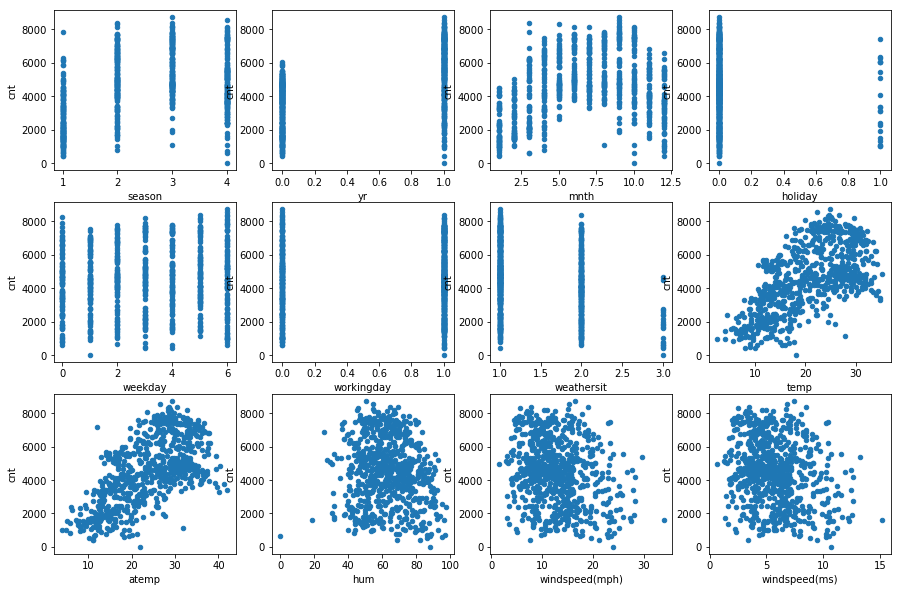

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

выводы:
1. характер зависимости числа прокатов от месяца цикличный
2. линейная зависимость от: temp, atemp

In [5]:
# считаем корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df[df.columns[:-1]].corrwith(df.cnt)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

есть коррелирующие признаки - можно делать линейными методами

In [6]:
# попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[df.columns[7:]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


In [7]:
# средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб - надо нормировать

### коллинеарные признаки

масштабирование с помощью метода scale.

перемешиваем

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

обучение линейной регрессии на данных

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
# создаем объект линейного регрессора, обучаем
# (веса хранятся в переменной coef_ класса регрессора).
# выводим пары (название признака, вес)
# названия признаков - в переменной df.columns
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
zip(df.columns,linear_regressor.coef_)

[('season', 570.87166018881931),
 ('yr', 1021.9681141542968),
 ('mnth', -141.30471071341395),
 ('holiday', -86.756216845717375),
 ('weekday', 137.22340368157441),
 ('workingday', 56.393735828395506),
 ('weathersit', -330.2317081049294),
 ('temp', 367.47305679011254),
 ('atemp', 585.55786521602681),
 ('hum', -145.60737566070202),
 ('windspeed(mph)', 12457919068698.219),
 ('windspeed(ms)', -12457919068896.668)]

веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках

Обучение регрессоров Ridge и Lasso с параметрами по умолчанию

In [12]:
from sklearn.linear_model import Lasso, Ridge

In [13]:
# обучаем линейную модель с L1-регуляризацией и выводим веса
lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
zip(df.columns,lasso_regressor.coef_)

[('season', 560.2416160308868),
 ('yr', 1019.4634940657199),
 ('mnth', -128.73062703678758),
 ('holiday', -86.152781333711047),
 ('weekday', 137.34789390496303),
 ('workingday', 55.21237064135682),
 ('weathersit', -332.36985696234876),
 ('temp', 376.3632362096975),
 ('atemp', 576.53079350455221),
 ('hum', -144.12915500348589),
 ('windspeed(mph)', -197.13968940248512),
 ('windspeed(ms)', -2.8050416772134453e-08)]

In [14]:
# обучаем линейную модель с L2-регуляризацией и выводим веса
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
zip(df.columns,ridge_regressor.coef_)

[('season', 563.06457225201257),
 ('yr', 1018.9483787875281),
 ('mnth', -131.87332028247269),
 ('holiday', -86.746097997092548),
 ('weekday', 138.00511117871898),
 ('workingday', 55.903110375064493),
 ('weathersit', -332.34978849907299),
 ('temp', 386.45788919194382),
 ('atemp', 566.3470470600322),
 ('hum', -145.0713272986724),
 ('windspeed(mph)', -99.25944108184116),
 ('windspeed(ms)', -99.259441154292418)]

### убираем неинформативные признаки

применяем L1-регуляризацию, она обнуляет веса при некоторых признаках

In [15]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучаем регрессор Lasso
# записываем веса в соответствующую строку матрицы coefs_lasso 
# обучаем Ridge и записываем веса в coefs_ridge.

for ind, a in enumerate(alphas):
    # блок Lasso
    lasso_regressor_alpha = Lasso(alpha=a)
    lasso_regressor_alpha.fit(X, y)
    coefs_lasso[ind] = lasso_regressor_alpha.coef_
    
    # блок Ridge
    ridge_regressor_alpha = Ridge(alpha=a)
    ridge_regressor_alpha.fit(X, y)
    coefs_ridge[ind] = ridge_regressor_alpha.coef_
# печатаем по 2 строки для контроля
print 'coefs_lasso, 2 строки:\n', coefs_lasso[:2], '\n'
print 'coefs_ridge, 2 строки:\n', coefs_ridge[:2]

coefs_lasso, 2 строки:
[[  5.60241616e+02   1.01946349e+03  -1.28730627e+02  -8.61527813e+01
    1.37347894e+02   5.52123706e+01  -3.32369857e+02   3.76363236e+02
    5.76530794e+02  -1.44129155e+02  -1.97139689e+02  -2.80504168e-08]
 [  4.10969632e+02   9.77019409e+02  -0.00000000e+00  -5.34489688e+01
    9.19434374e+01   1.75372118e+01  -3.18125568e+02   3.22829934e+02
    6.10031512e+02  -9.10689615e+01  -1.45066095e+02  -2.29877063e-08]] 

coefs_ridge, 2 строки:
[[  563.06457225  1018.94837879  -131.87332028   -86.746098     138.00511118
     55.90311038  -332.3497885    386.45788919   566.34704706  -145.0713273
    -99.25944108   -99.25944115]
 [  461.1786324    954.30774189   -41.56545001   -84.91347027
    126.60366663    54.2516911   -313.27515141   458.90147709
    481.44350031  -151.29101033  -101.62731482  -101.62731483]]


Визуализируем динамику весов при увеличении параметра регуляризации:

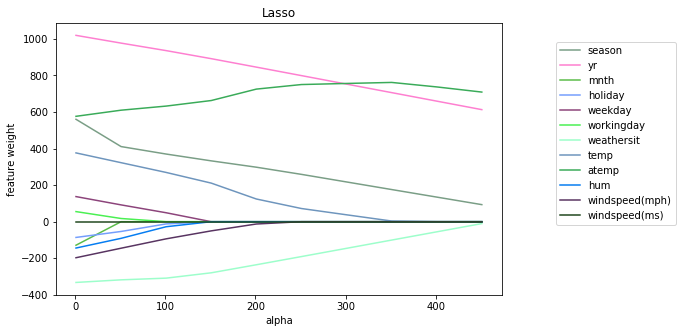

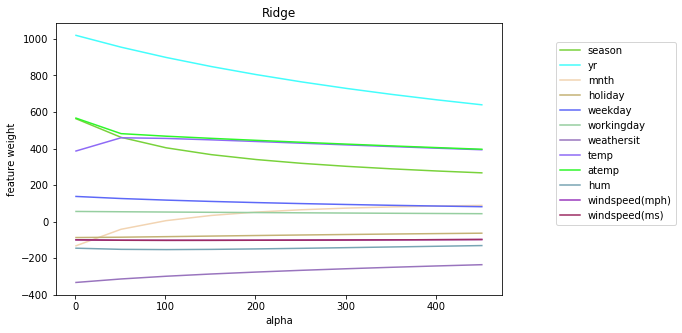

In [16]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

работаем с Lasso

нужна метрика качества, используем Mean Square Error.

будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. 

делаем разбиения кросс-валидацией

In [17]:
from sklearn.linear_model import LassoCV

In [18]:
# обучаем регрессор LassoCV на всех параметрах регуляризации из alpha
# строим график _усредненного_ по строкам MSE в зависимости от alpha. 
# выводим выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)

In [19]:
# обучаем регрессор LassoCV на всех параметрах регуляризации из alpha
lassoCV_regressor = LassoCV(alphas=alphas)
lassoCV_regressor_alpha = lassoCV_regressor.fit(X, y)

In [20]:
# печать для контроля
print lassoCV_regressor_alpha.alphas_
zip(lassoCV_regressor_alpha.alphas_, lassoCV_regressor_alpha.mse_path_)

[96 91 86 81 76 71 66 61 56 51 46 41 36 31 26 21 16 11  6  1]


[(96, array([ 863936.50981215,  826364.11936907,  862993.29751896])),
 (91, array([ 860479.31511365,  821110.1817776 ,  853075.13780625])),
 (86, array([ 857344.83606082,  816153.27782428,  843628.81286098])),
 (81, array([ 854526.73639431,  811496.34805693,  834654.45357262])),
 (76, array([ 852024.62341384,  807139.39657173,  826152.16399015])),
 (71, array([ 849838.18755425,  803082.42338526,  818122.01934907])),
 (66, array([ 847967.16232762,  799325.42849761,  810564.07404745])),
 (61, array([ 846411.31812808,  795868.41190876,  803478.36741509])),
 (56, array([ 845170.45707972,  792711.37361871,  796864.92788593])),
 (51, array([ 844244.40861679,  789854.31362747,  790723.77601555])),
 (46, array([ 843633.02568868,  787297.23193504,  785058.69560905])),
 (41, array([ 843336.18149882,  785040.12854141,  779861.12465128])),
 (36, array([ 843353.76670095,  783083.00344659,  775139.90236011])),
 (31, array([ 843616.44582031,  781425.85665058,  770886.43550572])),
 (26, array([ 843608

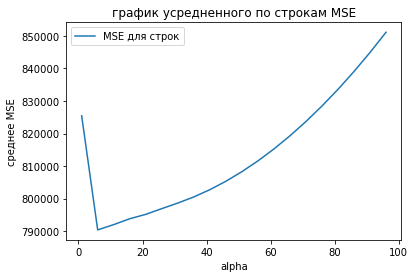

In [21]:
# строим график _усредненного_ по строкам MSE в зависимости от alpha
plt.figure()
lassoCV_regressor_alpha.mse_path_.mean
plt.plot(lassoCV_regressor_alpha.alphas_, lassoCV_regressor_alpha.mse_path_.mean(axis=1), label=u'MSE для строк')
plt.legend()
plt.xlabel("alpha")
plt.ylabel(u"среднее MSE")
plt.title(u"график усредненного по строкам MSE")
plt.show()

In [22]:
# выводим выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
print 'выбранное альфа =', lassoCV_regressor_alpha.alpha_, '\n'
print 'соответствующие обученные веса:'
zip(df.columns, lassoCV_regressor_alpha.coef_)

выбранное альфа = 6 

соответствующие обученные веса:


[('season', 532.01898284135359),
 ('yr', 1015.0602226430593),
 ('mnth', -100.03952614356638),
 ('holiday', -83.293959875299095),
 ('weekday', 132.50446549095807),
 ('workingday', 51.557085614073848),
 ('weathersit', -330.55985673998123),
 ('temp', 370.67985503003598),
 ('atemp', 581.39693106549589),
 ('hum', -140.00740550068895),
 ('windspeed(mph)', -191.77140847135107),
 ('windspeed(ms)', -2.6854208375775755e-08)]

контрольные вычисления

In [23]:
# выводим значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируем столбцы .mse_path_
#lassoCV_regressor_alpha.mse_path_

In [24]:
# выводим значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
for i in range(3):
    print 'альфа минимума для столбца {} равно: {}\n'.format(i, lassoCV_regressor_alpha.alphas_[lassoCV_regressor_alpha.mse_path_.argmin(axis=0)[i]])

альфа минимума для столбца 0 равно: 41

альфа минимума для столбца 1 равно: 6

альфа минимума для столбца 2 равно: 1



График для 0-го столбца переменной mse_path_


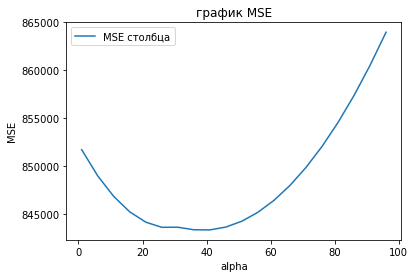

График для 1-го столбца переменной mse_path_


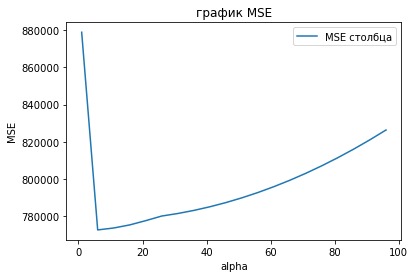

График для 2-го столбца переменной mse_path_


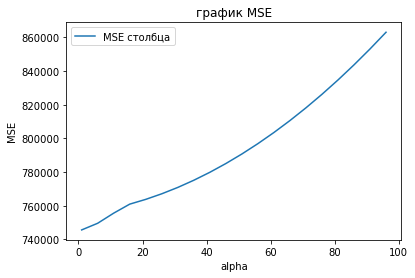

In [25]:
# визуализируем столбцы .mse_path_
for i in range(3):
    print 'График для {}-го столбца переменной mse_path_'.format(i)
    plt.figure()
    plt.plot(lassoCV_regressor_alpha.alphas_, lassoCV_regressor_alpha.mse_path_[:,i], label=u'MSE столбца')
    plt.legend()
    plt.xlabel("alpha")
    plt.ylabel(u"MSE")
    plt.title(u"график MSE")
    plt.show()
    

Примечание:

выборе alpha на кросс-валидации дает нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

### примечание
с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3)